# Normalizing flows
Deconvolving 3 Perpendicular Gaussians with MAFs

### inference without pre-processing:

#=============================================================================================================
INFO: created directory: ../../results/smeared_gaussians.DeconvolutionNormFlow.Couplings_RQS.2023.10.13_10h57
#=============================================================================================================
+---------------------+-----------------------+
| Parameters          | Values                |
+---------------------+-----------------------+
| DATA                | smeared_gaussians     |
| features            | ['x', 'y']            |
| num_points          | 37500                 |
| dim_input           | 2                     |
| noise_cov           | [[0.1, 0], [0, 1]]    |
| preprocess          | []                    |
| cuts                | x: [-inf, inf]        |
|                     | y: [-inf, inf]        |
| DEVICE              | cpu                   |
| optimizer           | Adam                  |
| lr                  | 0.0001              

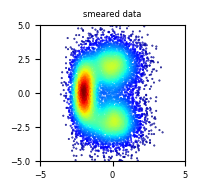

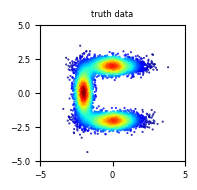

INFO: number of training parameters: 8065


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	 train loss: 3.8497438430786133, valid loss: 3.9832708835601807  (min valid loss: 3.9832708835601807)
	 train loss: 3.584916591644287, valid loss: 3.817009925842285  (min valid loss: 3.817009925842285)
	 train loss: 3.620803117752075, valid loss: 3.7420527935028076  (min valid loss: 3.7420527935028076)
	 train loss: 3.6759676933288574, valid loss: 3.7076776027679443  (min valid loss: 3.7076776027679443)
	 train loss: 3.6168735027313232, valid loss: 3.6994874477386475  (min valid loss: 3.6994874477386475)
	 train loss: 3.6536426544189453, valid loss: 3.684790849685669  (min valid loss: 3.684790849685669)
	 train loss: 3.6550469398498535, valid loss: 3.6672728061676025  (min valid loss: 3.6672728061676025)
	 train loss: 3.646674871444702, valid loss: 3.673907995223999  (min valid loss: 3.6672728061676025)
	 train loss: 3.65679669380188, valid loss: 3.65988826751709  (min valid loss: 3.65988826751709)
	 train loss: 3.64396333694458, valid loss: 3.6718082427978516  (min valid loss: 3.6536

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_gaussians(data, num_points=None, title=None, xlim=(-5,5), ylim=(-5,5)):
    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()


from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.deconvolution_configs import Deconvolution_Gauss_Couplings_RQS_NormFlow as Configs

configs = Configs(DATA = 'smeared_gaussians',
                num_points = 37500,
                data_split_fracs = [0.8, 0.2, 0.0],
                noise_cov = [[0.1, 0],[0, 1]],
                num_transforms = 5,
                dim_hidden = 16, 
                num_mc_draws = 50,
                num_blocks = 2,
                tail_bound = 10,
                num_bins = 10,
                batch_size = 512,
                mask = 'mid-split',
                EPOCHS = 100,
                early_stopping = None,
                min_epochs = None,
                print_epochs = 2,
                lr = 1e-4,
                weight_decay = 1e-5,
                num_workers = 8,
                pin_memory = True,
                DEVICE = 'cpu'
               )

#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

from DynGenModels.datamodules.deconvolution.datasets import SmearedGaussDataset
from DynGenModels.datamodules.deconvolution.dataloader import ToysDataLoader 
from DynGenModels.models.nflow_nets import CouplingsPiecewiseRQS
from DynGenModels.dynamics.nf.deconvolution import DeconvolutionNormFlows

dataset = SmearedGaussDataset(configs)
dataloader = ToysDataLoader(dataset, configs)
net = CouplingsPiecewiseRQS(configs)
dynamics = DeconvolutionNormFlows(net, configs)
coupl = DynGenModelTrainer(dynamics, dataloader, configs)

plot_gaussians(dataset.smeared, title='smeared data', num_points=10000)
plot_gaussians(dataset.truth, title='truth data', num_points=10000)

coupl.train()

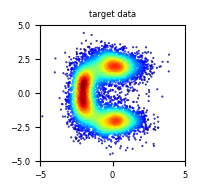

In [12]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 


pipeline = NormFlowPipeline(trained_model=coupl, 
                            configs=configs, 
                            num_gen_samples=10000, 
                            best_epoch_model=False)

plot_gaussians(pipeline.target, title='target data')

## Discusion

We wish to recover the truth distribution $q(y)$ (left plots) given the smeared one $p(x)$ (middle plots) and the noise model assumed to be Gaussian. This is equivalkent to the deconvolution problem $x = y + \epsilon$:

$p(x) = q\star \mathcal{N}(x) = \int d\epsilon\, p(x-\epsilon)\mathcal{N}(0, \Sigma^2)$

we show two cases: (i) 3 perependicular gaussian distributions and, (ii) the same distributions but with hard edges corresponding to cuts. This last situtation is a toy model for Gaia data where all stars fall inside a ball of fixed radius $R$.

The plots in the last column show the results for a trained normalizing flow deconvolution. The case without cuts works well, one can see that the procedure is trying to unsmear the data back to the truth shape. When cuts are imposed the deconvolution does not work well becasue of the data discontinuities. For this reason we need to use preprocessing...



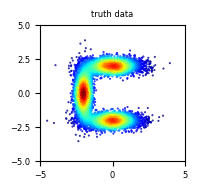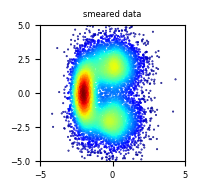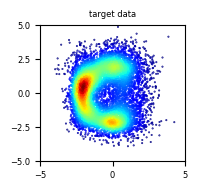

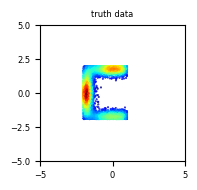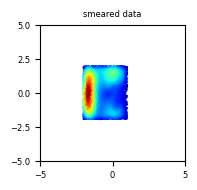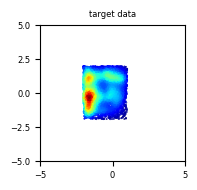

# Inference with preprocessing
The above deconvolution works pretty well... I run into issues when we decide to preprocess the data with non-linear fucntions

$\phi: x\to x^\prime$ 

The distroy the linearity $x = y+\epsilon$, i.e. the deinsity of $p(x^\prime)$ in the transfrimed space is no longer a convolution integral. One can see this explicitly in the results below: